***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)    
    * Previous: [5.3 Gridding and Degridding for using the FFT](5_3_gridding_and_degridding.ipynb)
    * Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](5_5_widefield_effect.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [2]:
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import HBox
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [3]:
from IPython.display import HTML, Javascript
HTML('../style/code_toggle.html')

***

## 5.4 The Dirty Image and Visibility Weightings <a id='imaging:sec:weights'></a>

Now that we have laid out the concepts of spatial filters, sampling and point spread functions, and gridding for using fast Fourier transforms, we are ready to connect all this topics into one to show how an image is produced from a radio interferomtric array observation. The so called 'dirty' image (the reason for this term relates to the deconvolution stage which is covered in the next chapter) from an observation is approximately

$$ I^{\textrm{D}}(l,m) \approx \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} S(u,v) \, V_{\textrm{obs}}(u,v) \, e^{-2\pi i(ul+vm)} \,du\,dv $$

where $V_{\textrm{obs}}(u,v)$ is the observated visibilities, this function is a complete, continuous measurement of the uv domain, which in reality is never measured because $S(u,v)$ is the sampling function, the main component of which is the uv coverage of the baseline tracks. This is an approximate result as we have used [van Cittert-Zernike Theorem &#10142;](../4_Visibility_Space/4_5_The_Fourier_Approximation_VanCittert-Zernike_Theorem.ipynb) approximation to reduce the complete 3-D visibility equation to 2-D. The limits to this approximation and how to correct for the 'w-term' is covered in the next section.

The sampling function $S$, as we have seen in the previous section on gridding, contains the uv track sampling and the gridding operator. And, as we will see later in this chapter, the sampling function will be generalized to include various 'weighting' functions. It is often useful to talk of the sampled visibilities

$$ V^{\textrm{S}} = S(u,v) \, V_{\textrm{obs}}(u,v) $$

which is combination of the visibility samples from all baselines onto a single visibility-space plane. Comparing the dirty image equation to that of the 2-D Fourier transform in Section [5.1 &#10142;](5_1_spatial_frequencies.ipynb) we see that the dirty image is simply the Fourier transform of the sampled visibilities.

$$ I^{\textrm{D}} = \mathscr{F}\{V^{\textrm{S}}\} = \mathscr{F}\{ S V_{\textrm{obs}}\}$$

The $(l,m)$ and $(u,v)$ notation has been dropped here for compactness. By Fourier theory ([$\S$ 2.5 &#10142;](../2_Mathematical_Groundwork/2_5_convolution.ipynb)) the dirty image can be interpreted as a convolution of two functions. 

$$ I^{\textrm{D}} = \mathscr{F}\{ S \} \circ \mathscr{F}\{ V_{\textrm{obs}}\}$$

As we have seen in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb) the first function $\mathscr{F}\{ S \}$ is the PSF response of the array, which we have seen is dependent on the array configuration, sky poisiton, observation time, and frequency coverage. The second function $\mathscr{F}\{ V_{\textrm{obs}}\}$ is the Fourier transform of the fully sampled visibility space. We never has access to $V_{\textrm{obs}}$, but as we will see in the [next chapter &#10142;](../6_Deconvolution/6_0_introduction.ipynb), we include *a priori* information to make an approximate reconstruction of $V_{\textrm{obs}}$ via deconvolution of the PSF. We can think of $\mathscr{F}\{ V_{\textrm{obs}}\}$ being the ideal image $I^{\textrm{ideal}}$ reconstructed from fulling sampling the visibility plane. Re-writing the equation above the dirty image is the convolution of the array PSF with the ideal image.

$$ I^{\textrm{D}} = \textrm{PSF} \circ I^{\textrm{ideal}}$$

Returning to examples from earlier in the chapter we can construct a dirty image from the original duck image and the KAT-7 PSF response from one of the observations in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb).

In [4]:
duck = mpimg.imread('figures/Anas_platyrhynchos_male_female_quadrat_512.png')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

gDuck = rgb2gray(duck)
fftDuck = np.fft.fft2(gDuck) #take the Fourier transform of the image to poduce the observed visibilities

In [5]:
hdulist = fits.open('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_100chans_natural-psf.fits')
psf = hdulist[0].data #shape [polarization, channel, m, l]
sampFunc = np.fft.fft2(psf[0,0]) #take the Fourier transform of the PSF to generate the gridded sampling function

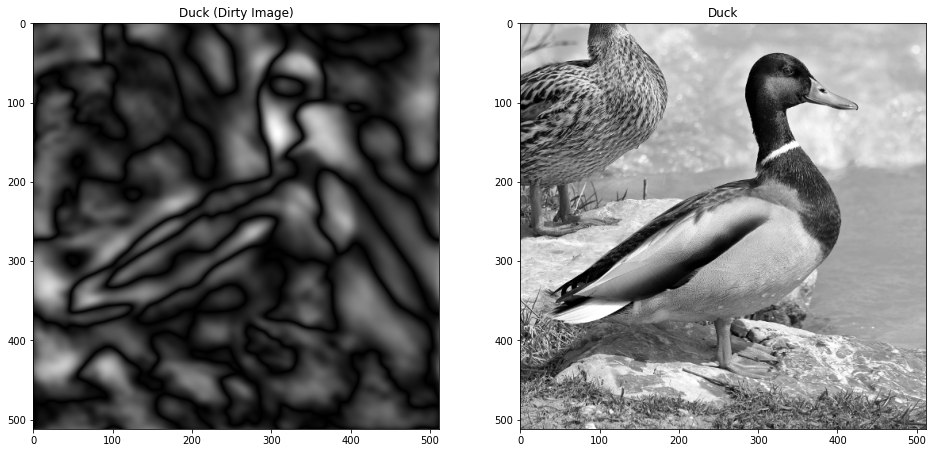

In [6]:
fig, axes = plt.subplots(figsize=(16,8))

ax1 = plt.subplot(1,2,1)
fftDirtyImg = sampFunc * fftDuck #multiplication in Fourier space is equivalent to convolution in image space
dirtyImg = np.abs(np.fft.fftshift(np.fft.ifft2(fftDirtyImg))) #create the dirty image
plt.title('Duck (Dirty Image)')
imgPlot0 = plt.imshow(dirtyImg)
imgPlot0.set_cmap('gray')

ax2 = plt.subplot(1,2,2)
plt.title('Duck')
imgPlot1 = plt.imshow(gDuck)
imgPlot1.set_cmap('gray')

*Figure: dirty image of a duck (left) created by sampling the original duck image (right) with a KAT-7 observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

It is hard to make out the duck in the resulting dirty image. The head and long wing can be picked out, but that is likely due to the fact that we know what the original image looked like. Had we not known what the original image was we would have a difficult time deciding what we are seeing. This is the main issue in interferometric imaging, and has perpetuated the development of deconvolution algorithms.

Plotting the Fourier transform of the PSF should result in a similar image of the uv coverage plot seen in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb). Indeed it does, but notice that the color bar suggests a range of pixel values. This comes back to the overlapping uv tracks we saw in the uv coverage plots and the type of weighting scheme which was used to produce the PSF. We have been hiding a few details up until this point to simplify the presentation of sampling functions and how they affect resulting images. But, now we will generalize sampling function to introduce weighting functions.

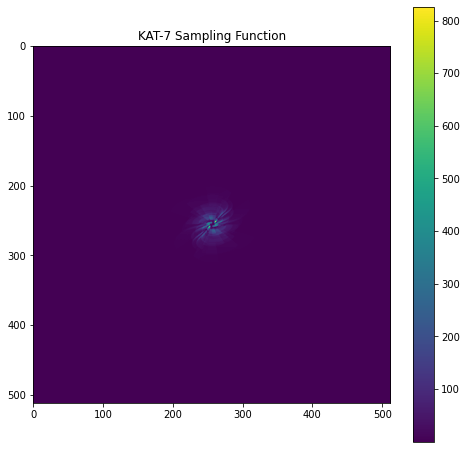

In [7]:
fig = plt.figure(figsize=(8,8))
plt.title('KAT-7 Sampling Function')
imgPlot = plt.imshow(np.abs(np.fft.fftshift(sampFunc)))
plt.colorbar()

*Figure: KAT-7 sampling function for an observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

### 5.4.1 Weighting Functions, a generalization of sampling functions

The sampling function, as seen in the Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb) KAT-7 examples, are made up of the various baseline tracks which leads to holes and overlapping sampling of the visibility domain. So far we have discussed sampling functions as if they are binary functions, a visibility domain pixel is given a value of 1 if a baseline track measured that location otherwise the pixel was given a value of 0. The allocation of 0 to each pixel which was not measured should make sense, as there is no information, and thuse that pixel can potentially have any value. But, for the measured pixels the sampling function value does not necessarily need to be 1. For example, say an observation results in 1000 uv positions being measured, and 100 of these positions were measured 10 times while the other 900 positions were only measured once. The 100 positions measured 10 times, will have a $\sqrt{10}$ improvement in sensitivity compared to the other 900 positions, so perhaps those 100 spatial frequency modes should be given more weight in the resulting image because we are more sure about the accuracy of the measurement. Or, perhaps an array is made up of many different types of telescopes which leads to some baselines having a higher sensitivity to other baselines, such as in VLBI. Or, perhaps the science case is only interested in certain spatial frequencies, such as seperating point sources from large-scale gas structure. These are all examples of times when we would like to adjust our sampling function, which leads to a number of different options we need to understand when creating an image. In fact, there is no standard set of options to create an image from visibilities, a weighting function must always be decided upon before hand. The most common weighting function we must decide on when imaging is the density weighting function, but we will also discuss the beam taper and reliability weighting.

As a simplification we have been discussing the PSF as being a Fourier pair of the visibility sampling function, but in fact we need to generalize to say that the PSF is a Fourier pair of a weighting function $W$, where $W$ includes the sampling function.

$$ \textrm{PSF}(l,m) \rightleftharpoons W(u,v)$$

Expanding $W$ we see that it is made up over a number of functions. For this section we will use the notation based on Lecture 7 of [<cite data-cite='1999ASPC..180.....T'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/abs/1999ASPC..180.....T). For compactness the $(u,v)$ terms have been dropped.

$$ W = R \cdot T \cdot D \cdot S $$

$W$ is a product of the the sampling function $S$ which we have all ready discussed, a density weight function $D$, an optional taper weight function $T$, and a baseline-dependent reliability weight function $R$.

As a simple example let us look at some 1-D weight functions and the resulting PSFs. For this example lets say we sample the inner centre of a 1-D function. This results in a square or boxcar sampling, as seen in blue in the left-hand figure below. But, say we think some samples are 'better' than others. For example, our detector has a linear response based on the distance from the zero point. Then, we would like to weigh the samples accordingly, giving more weight to samples near the centre and less to the samples on the far edges. This results in a triangle weight function, as seen in green in the left-hand figure below. Or, perhaps a Gaussian weighting function, red in the left-hand figure below, is more appropriate. There are many types of potential weighting functions which all cover the same extent of the sample space. But, these weighting functions result in different PSF responses as seen in the right-hand figure. Using a boxcar weighting function (blue) results in the highest PSF primary lobe, but the sidelobes are significantly higher compared to other weighting functions. This relates to the idea that a smooth function in one domain is also a smooth function in its Fourier domain, and a boxcar function is not a smooth function. A Gaussian function is a smooth function, but the sampling extent (or window in signal processing terms) is finite, this means that there is a cut-off point. The PSF response of a truncated Gaussian (green) has a wider primary lobe but lower sidelobes compared to the boxcar function. As does the triangle function which can as a simple approximation to the Gaussian.

(0.0, 512.0)

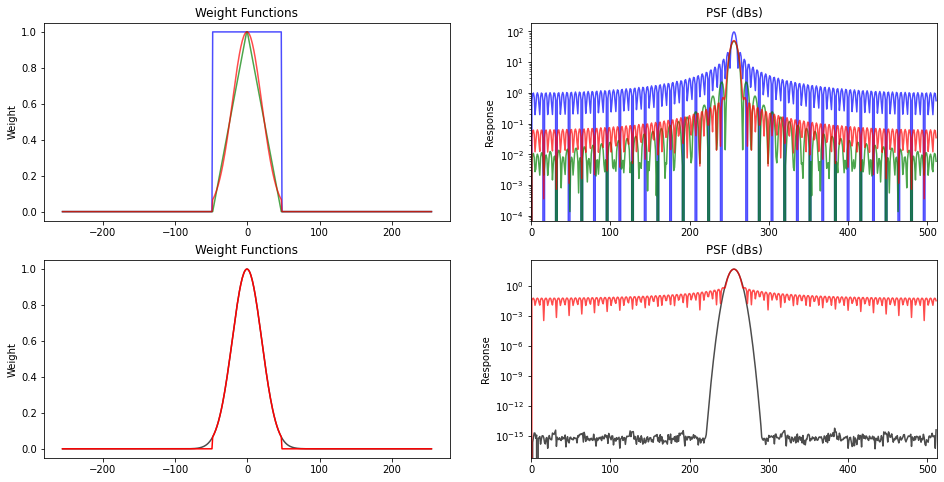

In [8]:
from scipy import signal

whw = 48 #window half width

#Square/Boxcar weight function
squareWeights = np.zeros(512, dtype='float')
squareWeights[256 - whw:256 + whw] = 1.

#Triangle weight function
triWeights = np.zeros(512, dtype='float')
triWeights[256 - whw : 256] = np.linspace(0., 1., num=whw)
triWeights[256 : 256 + whw] = np.linspace(1., 0., num=whw)

#Gaussian weight function
gaussWeights = signal.gaussian(512, std=whw / (2. * np.sqrt(2. * np.log(2.))))
truncGaussWeights = gaussWeights * squareWeights #truncate to window width

xVals = np.arange(-256,256)

fig, axes = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(2,2,1)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, squareWeights, 'b-', alpha=0.7)
plt.plot(xVals, triWeights, 'g-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=0.7)
#plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)

ax1 = plt.subplot(2,2,2)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(squareWeights))), 'b-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(triWeights))), 'g-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
#plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

ax1 = plt.subplot(2,2,3)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=1.0)

ax1 = plt.subplot(2,2,4)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

*Top: examples of 1-d weight functions: square (blue), triangle (green), truncated Gaussian (red) and the resulting PSF responses.*

*Bottom: Gaussian (black) and truncated Gaussian (red) weighting function and the resulting PSF responses. The low level 'noise' in the Gaussian response is due to computational accuracy limits.*

The figure above shows just three possible weighting functions and the resulting PSF responses. There is no 'correct' function, each has advantages and disadvantages. A boxcar function maximizes the PSF primary lobe response but at the expense of high sidelobes. A triangle function minimizes sidelobes but at the expense of some loss in signal, and a loss of resolution (as does the Gaussian). This loss in resolution (that is a wider primary lobe) is because the weight function gives more value to the samples near the centre point, i.e. the lower spatial modes.

As we will see, we can decide on a weighting function when synthesising an image to emphasize for resolution or sensitivity or a combination of the two in the density weighting funciton.

### 5.4.2 Density Functions

When discussion of weighting functions (or schemes) comes up in conversations, presentations, or papers it is almost always referring to *density weighting functions*. A density weighting function is used to set the weights of individual uv positions based on the number of times that position is sampled in an observation. One will often see terms such as 'uniform' and 'natural' weighting which are types of density weighting functions.

Going back to the KAT-7 sampling function plot shown earlier, we see that the pixels range in values. That is, during the observation those pixels in the visibility domain were sampled multiple times due to a combination of the frequency bandwidth coverage and the uv track positions. In this case, when we formed the PSF response we decided to give each sample a equal weighting, this resulted in the pixels have a range of weights. This is similar to the Gaussian weighting function in the 1-d example above. This weighting scheme is called *natural weighting* (or inverse variance weighting), it has the advantage of maximizing sensitivity but at the cost of resolution. It is often stated in literature that natural weighting lead to broad 'wings' in the PSF primary lobe, this is due to the over representation of the low spatial frequency modes.

A complimentary weight scheme is *uniform weighting* (or unity weighting) which weights each sample positon equally, not matter how many times that position was sampled. This is akin to the boxcar weighting function in the 1-d example above, and results in a higher resolution image at the cost of higher PSF sidelobes.

As covered in the [gridding section &#10142;](5_3_gridding_and_degridding.ipynb), when gridding the sampled visibilities are placed into pixels, that is a 2-D grid array. If no samples are placed in a pixel then that pixel obviously is given zero weight. For a given pixel, if only one sample is placed at that position then it would seem we could justify giving that pixel a weight of one. But, as we have seen, multiple samples, or 'portion' of samples can be placed in a single pixel. If a sample is split between multiple pixels the total allocated weight of the combined positions for that sample should equal one, e.g. if a pixel is split between two pixels $(p_a, p_b)$, with 60% of the flux belonging in $p_a$ and 40% in $p_b$ then the sample is given a weight of 0.6 in $p_a$ and 0.4 in $p_b$. For multiple samples, the weight is the sum of the number of samples. Thus, we define a function $N_s(u,v)$ which returns the number of samples for a given pixel $(u,v)$. A natural weighting function is

$$ D_{\textrm{natural}}(u,v) = N_s(u,v)$$

and a uniform weighting function is

$$ D_{\textrm{uniform}}(u,v \, | \, t) = 
\begin{cases} 
    \hfill 1    \hfill & : N_s(u,v) > t  \\
    \hfill 0 \hfill & : N_s(u,v) \leq t \\
\end{cases}
$$

where $t$ is a non-negative threshold parameter, usually $t = 0$.

When to use a specific weighting scheme depends on the scientific aim of the observation. If you are trying to maximize resolution and are willing to lose some sensitivty then you use uniform weighting. And, if you are observing a weak source and are willing to lose some resolution then you use natural weighting. In the figures below a dirty image is show for natural and uniform weighting based on the same sky.

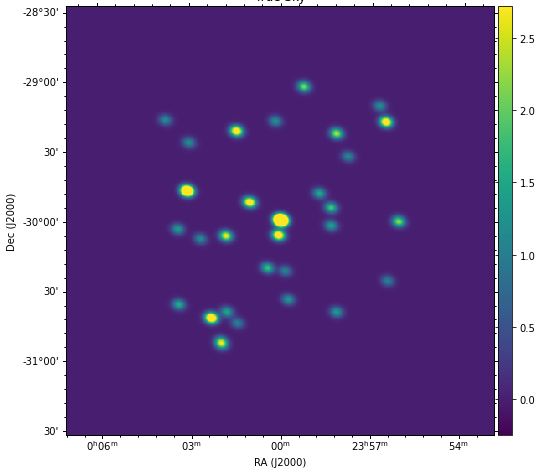

In [11]:
fig = plt.figure(figsize=(8, 8))

gc1 = aplpy.FITSFigure('../data/fits/true/KAT-7_6h60s_dec-30_10MHz_10chans_true.fits', figure=fig)
gc1.show_colorscale(cmap='viridis')
#gc1.show_colorscale(vmin=-2.5, vmax=5., cmap='viridis')
# gc1.hide_axis_labels()
# gc1.hide_tick_labels()
plt.title('True Sky')
gc1.add_colorbar()

fig.canvas.draw()

*Figure: map of the simulated sky, each source has been convolved with a 2-D Gaussian in this figure but the real sky is made up of point sources.*

AttributeError: 'FITSFigure' object has no attribute 'hide_axis_labels'

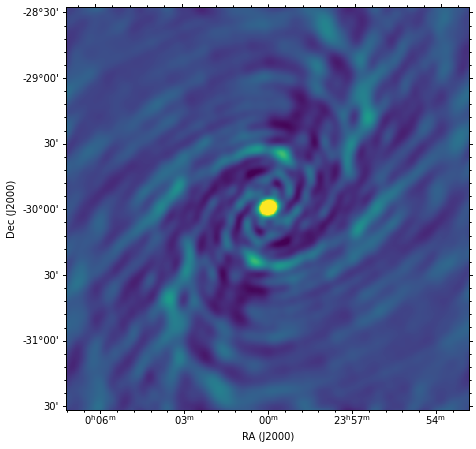

In [12]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits', figure=fig, \
                       subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-0.12, vmax=0.4, cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('PSF (Natural Weighting)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-psf.fits', figure=fig, \
                       subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-0.12, vmax=0.4, cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('PSF (Uniform Weighting)')
gc2.add_colorbar()

fig.canvas.draw()

fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_natural-dirty.fits', figure=fig,
                       subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-2.5, vmax=5., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Dirty Image (Natural Weighting)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-dirty.fits', figure=fig,
                       subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(-2.5, vmax=5., cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('Dirty Image (Uniform Weighting)')
gc2.add_colorbar()

fig.canvas.draw()

*Top: KAT-7 PSF using natural weighting (left) and uniform weighting (right).*

*Bottom: dirty image of a simulated field using natural weighting (left) and uniform weighting (right). Only the brighest sources can be seen, many of the weaker sources are hidden in the PSF sidelobe noise.*

The source in the naturally-weighted image appear to be larger, due to the larger PSF response, compared to the uniformly-weighted image. The uniformly-weighted image has noticable 'ringing' around sources due to the sinc-like nature of the uniformly-weighted PSF response. This results in more negative PSF sidelobes compared to the smoother naturally-weighted PSF response.

The idea of an adjustable parameter-based density weighting function was introduced Daniel Briggs' thesis [<cite data-cite='briggs1995high'>High Fidelity Deconvolution of Moderately Resolved Sources</cite> &#10548;](http://www.aoc.nrao.edu/dissertations/dbriggs/). The fundamental idea presented in this thesis was that natural and uniform weighting were simply two schemes on a continuum of possible weighting schemes controlled by a single parameter called the robustness. For this reason, this generalized weighting scheme is called robust weighting (it is also often called Briggs' weighting). The robustness parameter $R$ was developed such that at its two extreme values robust weighting approximated natural and uniform weighting and the zero point for $R$ represents an equal balance between resolution and image variance. The exact implementation of robust weighting varies between imagers, but all imagers should produce similar results.

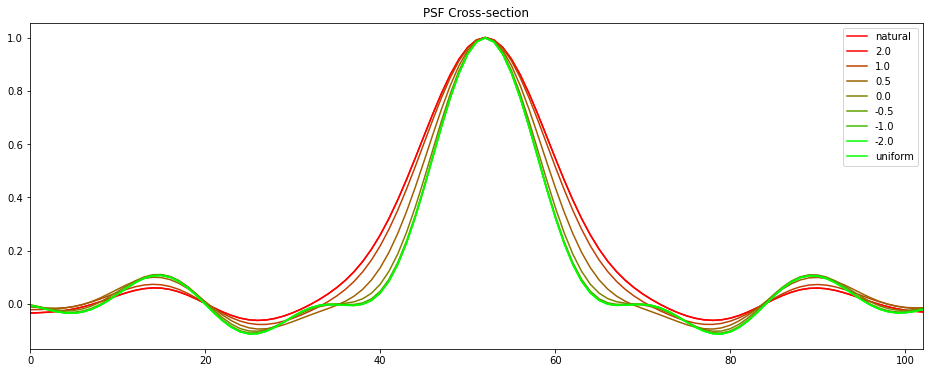

In [13]:
import collections
psfDict = collections.OrderedDict()
psfDict['natural'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits'
psfDict['2.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r2.0-psf.fits'
psfDict['1.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r1.0-psf.fits'
psfDict['0.5'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r0.5-psf.fits'
psfDict['0.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r0.0-psf.fits'
psfDict['-0.5'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-0.5-psf.fits'
psfDict['-1.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-1.0-psf.fits'
psfDict['-2.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-2.0-psf.fits'
psfDict['uniform'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-psf.fits'

fig = plt.figure(figsize=(16, 6))
for key in psfDict:
    fh = fits.open(psfDict[key])
    img = fh[0].data
    psfSlice = img[0,0,int(img.shape[2]/2.)] #take central slice
    subPsfSlice = psfSlice[int(2.*psfSlice.shape[0]/5.):int(3.*psfSlice.shape[0]/5.)] #take inner fifth
    if key=='natural':
        c = [1.0, 0.0, 0.0]
    elif key=='uniform':
        c = [0.0, 1.0, 0.0]
    else:
        norm = (float(key) + 2.)/4.
        c = [norm, 1.0-norm, 0.0]
    plt.plot(subPsfSlice, label=key, color=c)
plt.title('PSF Cross-section')
plt.xlim(0, subPsfSlice.shape[0]-1)
plt.legend()

*Figure: Cross-section of the KAT-7 PSF for natural, uniform, and a range of robust weighting functions. Natural weighting (red) results in the smallest absolute amplitude sidelobes but at the price of a wider main lobe. Uniform weighting (green) results in the narrowest main lobe but the cost of larges sidelobes. Robust weighting allows for parameterized control to make a trade off between main lobe resolution and sidelobe levels. Robustness of -2 is approximately the same as uniform weighting, and a robustness of 2 is approximately the same at natural weighting.*

A weighting function is robust if visibility samples which are oversampled during an observation are favoured over the less well-sampled visibilities, i.e. a natural weighting. Thus, a positive robustness parameter results in a weighting similar to the natural weighting, and a negative robustness results in a weighting similar to uniform weighting.

A robust weighting with $R = -2$ results in an approximately uniform weighting, and $R = 2$ results in an approximately natural weighting. The robust weighting formalization also allows for $|R| > 2$. An $R > 2$ overweights the most oversampled visibility (from the shorter baselines), this will result in lower resolution than natural weighting and smoother sidelobe characteristics, this may be useful when one is interested in imaging large, diffuse structure. An $R < -2$ will up-weight the least sampled visibilities (longest baselines) which results in a a higher resolution image than uniform weighting but also with higher sidelobe characteristics. This may be useful if one is imaging a field which has high signal to noise sources and wish to better resolve those sources.

In the case where baselines are relatively evenly spread out (such as the KAT-7 example above) the choise of density weighting function is not too important. However, when imaging on core-dense arrays such as MeerKAT array release 1, and in the future SKA MID, it plays an important role. In both these cases a large portion of the baselines falls in the low spatial frequency region, thereby effectively over-emphasising measurements taken in that region. You can see the effect this has on the PSF. In these instances choosing natural weighting will create a halo-like structure around sources, whereas uniform weighting will significantly increase angular resolution.

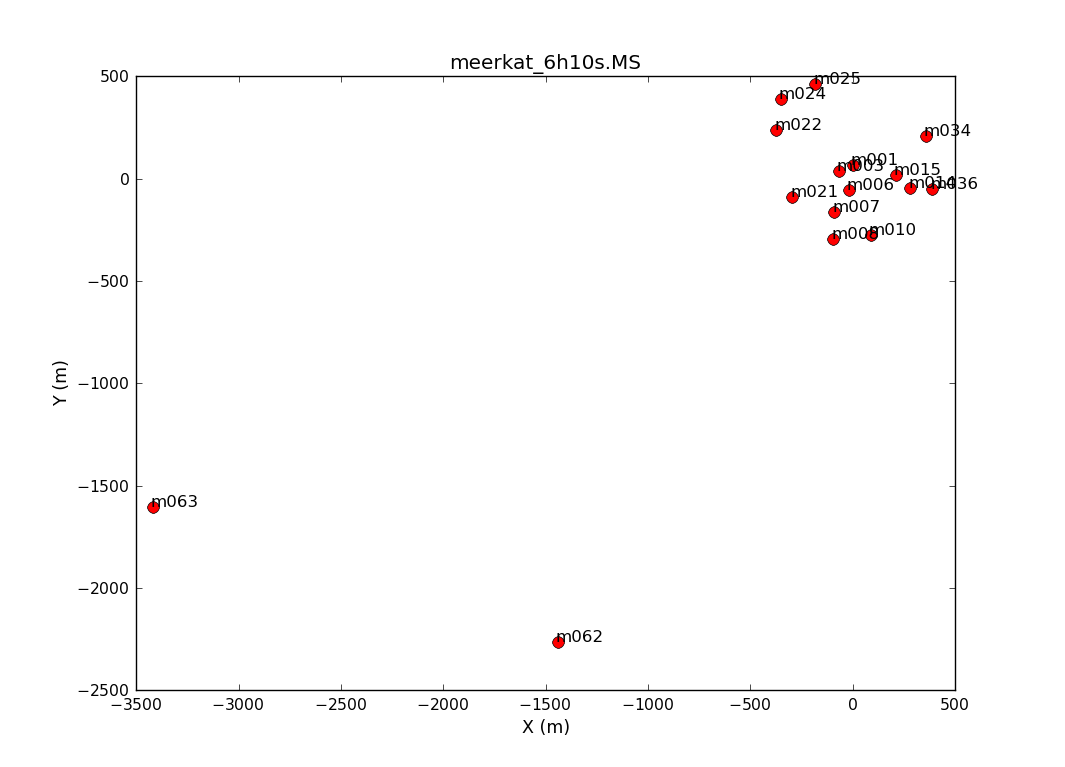

In [14]:
Image(filename="figures/meerkat_AR1.png")

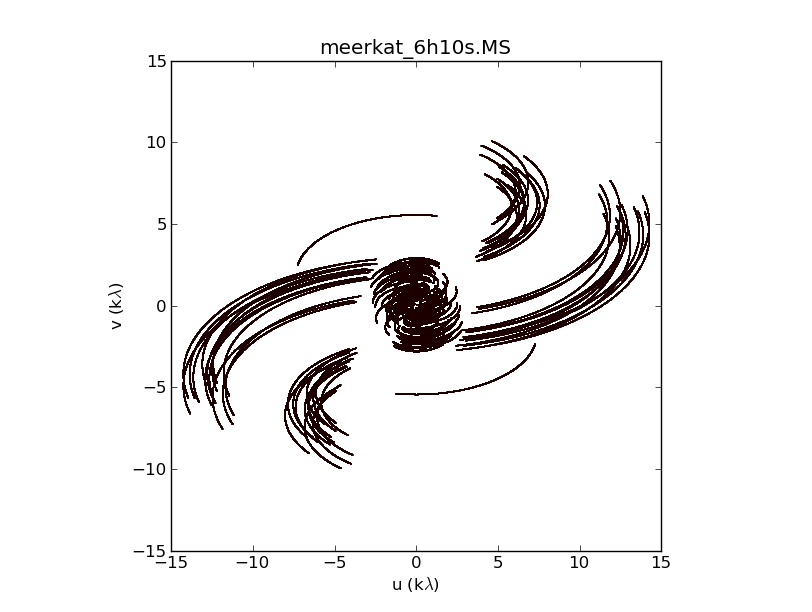

In [15]:
Image(filename="figures/meerkat_16hr_1.1ghz.png")

*Figure: Antenna positions of MeerKAT array release 1 and its associated UV coverage at 1.1GHz for a 6 hour observation. This configuration is especially core dense compared to, for example, the JVLA and KAT-7*

In [16]:
import collections
psfDict = collections.OrderedDict()
psfDict['2.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs2.0-psf.fits'
psfDict['1.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs1.0-psf.fits'
psfDict['0.5'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs0.5-psf.fits'
psfDict['0.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs0-psf.fits'
psfDict['-0.5'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-0.5-psf.fits'
psfDict['-1.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-1-psf.fits'
psfDict['-2.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-2-psf.fits'

fig = plt.figure(figsize=(16, 6))
for key in psfDict:
    fh = fits.open(psfDict[key])
    img = fh[0].data
    psfSlice = img[0,0,int(img.shape[2]/2.)] #take central slice
    subPsfSlice = psfSlice[int(2.*psfSlice.shape[0]/5.):int(3.*psfSlice.shape[0]/5.)] #take inner fifth
    norm = (float(key) + 2.)/4.
    c = [norm, 1.0-norm, 0.0]
    plt.plot(subPsfSlice, label=key, color=c)
plt.title('PSF Cross-section')
plt.xlim(0, subPsfSlice.shape[0]-1)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs2.0-psf.fits'

<Figure size 1152x432 with 0 Axes>

Uniform, natrual, and robust are not the only weighting schemes. There are array specific ones such as radial weighting which is used with east-west arrays. And, there is super- and sub-uniform weighting which are used to break the dependence of the PSF to the image pixel resolution and field of view. When imaging the pixel resolution and and number of pixels (field of view imaged) is adjustable. This means that the scale of the a pixel will change depending on these parameters. Thus, a low resolution image will include more visibility samples per pixel compared to a higher resolution image, and result in a different PSF response even when using the same weighting function. Super- and sub-uniform weighting can be used to set a fixed grid size for the weighting which is independent of the image resolution. This allows for PSF consistancy across different image resolutions and fields of view.

### 5.4.3 Taper Functions

A more generalized form of the density function is a taper function. These two functions are presented as different functions since they serve different purposes. While the density function is used to balance between resolution and sensitivity, taper functions are used for applying smooth image-domain filters. An interferometric array measures a range of spatial frequency scales, but say we are only interested in measuring a particular range of those scales. Say we know the size scale of a source that is being observed, or that we do not care about resolving a source but rather maximizing the signal to noise of that source. A taper function acts as a 'matched filter' for a specific signal of interested and is the same as 2-D window functions used in digital signal processing. If the response for a source is known then the signal to noise can be maximized by using the same response as a taper function. [Appendix A &#10142;](5_A_matched_filter.ipynb) of this chapter discusses the use of matched filters in aperture synthesis.

Though the taper function can be any 2-D function, in practice it is usually chosen to be smooth. Commonly a 2-D Gaussian is used as this allows for a set image-domain scale to be converted to a visibility-domain scale, as the Fourier transform of a Gaussian is also a Gaussian (the amplitude scale factors will be different requiring normalization). See [Wikipedia:Window Functions &#10548;](https://en.wikipedia.org/wiki/Window_function) for details on other taper functions.

The scale of interest in an image can be set the full-width half-maximum of a Gaussian $\theta_{\text{FWHM}}$ in radians. That is, we would like to convolve the image with a 2-D Gaussian

$$ \text{Gauss}(l,m\, | \, \sigma_{I}) = e^{\frac{-(l^2 + m^2)}{2\sigma_{I}^2}}$$

where $\sigma_{I}$ is the standard deviation of the function in radians (we are assuming we want a radially symetric Gaussian), and $\theta_{\text{FWHM}} = 2 \sqrt{2 \ln{2}}\sigma_{I}$. This is the taper response function, which is the Fourier pair to the taper function. The uv-domain Gaussian taper function scale can be related to the taper response function with $\sigma_{uv} = \frac{1}{2\pi\sigma_{I}}$ where $\sigma_{uv}$ is in unit number of wavelengths. The resulting (unnormalized) Gaussian taper function is

$$ \text{Gauss}(u,v\, | \, \sigma_{uv}) = e^{\frac{-(u^2 + v^2)}{2\sigma_{uv}^2}} = e^{\frac{-(u^2 + v^2) \pi^2 \theta_{\text{FWHM}}^2}{2 \ln{2}}}$$

Text(0.5, 1.0, 'Taper Function (uv domain)')

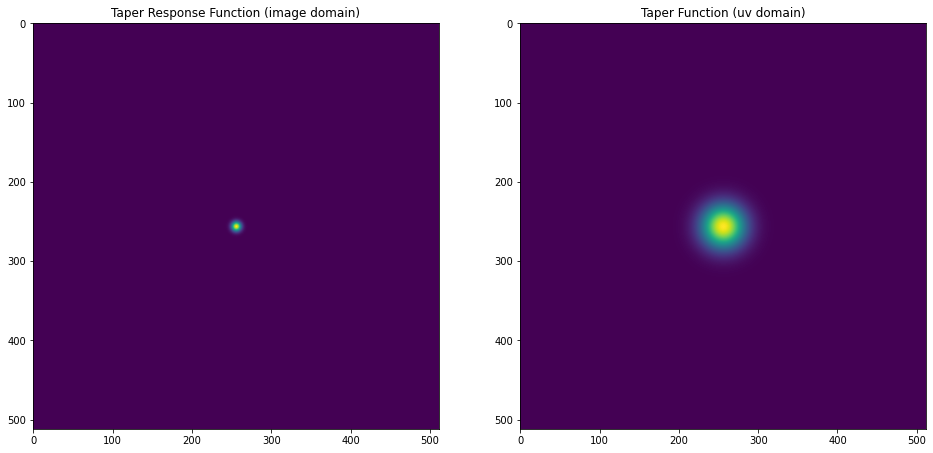

In [17]:
def gaussianTaperResponse(imSize, fwhmTheta):
    #Create an image-domain Gaussian taper response
    #imSize: [int, int] image size
    #fwhmTheta: full-width half-maximum in pixels
    lpos, mpos = np.mgrid[0:imSize[0],0:imSize[1]]
    sigma = fwhmTheta / (2. * np.sqrt(2. * np.log(2)))
    taper = np.exp(-1. * (((lpos - (imSize[0]/2.))**2. + (mpos - (imSize[1]/2.))**2.) / (2. * sigma**2.)))
    return taper

fig = plt.figure(figsize=(16, 8))

plt.subplot(121)
taperResponse = gaussianTaperResponse([512, 512], 10)
plt.imshow(taperResponse, cmap='viridis')
plt.title('Taper Response Function (image domain)')

plt.subplot(122)
taperedFunc = np.abs(np.fft.fftshift(np.fft.fft2(taperResponse)))
plt.imshow(taperedFunc, cmap='viridis')
plt.title('Taper Function (uv domain)')

*Figure: image-domain Gaussian taper response function and the Fourier paired uv-domain taper function.*

A Gaussian taper function is equivalent to a smoothing filter used in image processing. Similarly, a sharpen filter could be used as a taper function to filter for compact object such as point sources.

Text(0.5, 1.0, 'Dirty Image (40 pixel taper)')

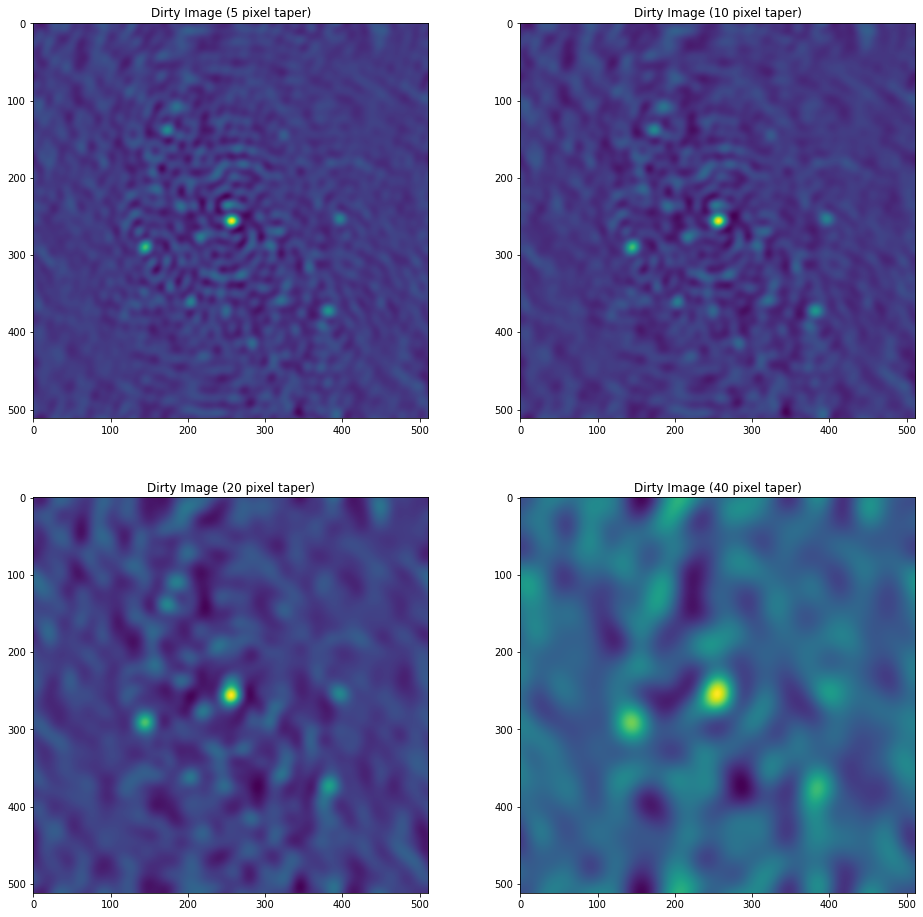

In [18]:
def convolveTaper(taperResponse, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(taperResponse) * np.fft.fft2(img))).real
    
fh = fits.open('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-dirty.fits')
img = fh[0].data[0,0]

fig = plt.figure(figsize=(16, 16))

plt.subplot(221)
taperResponse = gaussianTaperResponse(img.shape, 5)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (5 pixel taper)')

plt.subplot(222)
taperResponse = gaussianTaperResponse(img.shape, 10)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (10 pixel taper)')

plt.subplot(223)
taperResponse = gaussianTaperResponse(img.shape, 20)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (20 pixel taper)')

plt.subplot(224)
taperResponse = gaussianTaperResponse(img.shape, 40)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (40 pixel taper)')

*Figure: KAT-7 dirty image (uniform weighting) with different scale tapers applied (from top left clockwise: 5, 10, 20, 40 pixels).*

In the figures above the the resolution of the original dirty image was approximately 5 pixels, when a 5 pixel Gaussian taper function is applied (top left) there is no noticable effect on the image. But, as the taper size is increased the resolution is reduced as the lower spatial modes are upweighted compared to the higher spatial modes.

A randomly distributed array with a significant number of elements will result in an well-sampled, approximately Gaussian visibility sampling distribution. Using a uniform weighting with a taper function on the scale of the the Gaussian distribution of the visibilities will produce the same effective image as using natural weighting with no taper function.

### 5.4.4 Measurment Reliability Function

The last component of the weighting function is the measurement reliability function $R(u,v)$. This function is intrinsic to an array and observation. If an observation is made with an array of identical elements then the relative reliability of each visibility measurement would be the same. But, say one element of an array has a higher system temperature (i.e. it is noisier) or the element has a smaller dish (less sensitive) then any baseline correlation which includes this element will result in a noisier measurment and should be weighted as such. A priori information, such as an elements effective collection area or expected system temperature, can be included in this function. Variability in the performance of individual elements during an observation is also included in this function. For example, if one of the telescopes has a noisy amplifier which needs to be fixed compared to the other telecsopes in the array. For mixed arrays such as with VLBI each individual telescope will have a different sensitivity which needs to factored in. If no relibabilty weights are included in the original observation then this function is set to unity and ignored.

### 5.4.5 Limits of the Dirty Image

From the dirty images presented earlier in this section we can see that around the sources there are PSF-like sidelobes, but we know that this is an effect of the visibility sampling (our measurement instrument) and not the part of the true sky. So we can then ask, can we remove these sidelobes? And, what is the effect if we can? The answer to the second question is that if we can remove some of the larger sidelobes then we should be able to find other weaker sources in the field that could be hidden below, i.e. the noise floor of the image would be lower. We would say that the dynamic range increases if those sidelobes can be removed. The answer to the first question is that we can remove the structure imposed by the measurement to an extent by the use of deconvolution methods.

The term 'dirty image' came about after the initial development of synthesis imaging, the term was introduced when deconovlution methods, in particular the CLEAN method, were introduced to recover a 'better' image from the observed visibilities. The concept of better is subjective and not well-defined. But, the main idea is that a dirty image contains bright sources which are surrounded by PSF-like sidelobes due to the irregular visibility sampling. By making the assumption that the sky should be smooth and continuous then we can also assume the visibilities are smooth and continuous. Even though we are only sampling a portion of the visibilities we can use this assumption to enforce a smoothness which results in a 'clean' image in which the PSF has been deconvolved. This will be discussed in detail in the next chapter.

But, before we introduce deconvolution we will finish the chapter on the issue of imaging large field of views. At the start of this section we presented an equation which relates the dirty image to the measured visibilities, but this is an approximate equation. The w-term has been ignored to reduce the equation down to a 2-D Fourier transform. This equation holds well for a narrow field of view, but we are often interested in imaging larger fields of view with arrays spread over large areas. In order to do this the w-term must be included. A number of techniques are routinely used to effectively include preturbations to the simple 2-D Fourier relation between visibilities and the image to compensate for the missing w-term. This is that topic that will be covered in the next section.

***

Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](5_5_widefield_effect.ipynb)